In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

In [98]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import portfolio
from qiskit.aqua.translators.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA, COBYLA
from qiskit.aqua.components.variational_forms import RY
import qiskit.aqua.translators.ising.vehicle_routing as vr
import numpy as np
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import math

In [28]:
# Initialize the problem by defining the parameters
n = 4  # number of nodes + depot (n+1)
K = 1  # number of vehicles

In [26]:
#DataPrep
#Number of zones
no_zones=20
#Hub Coordinates
x0 = 1079; y0 = 507
#Customer coordinates
xs = np.array([1148,1093,1014,951,971,1035,978,958,873,797,861,780,702,775,659,647,577,550,552,621,431,405,340,190,128,189,352,289,284,152,90,71,89,123,158,381,377,438,528,599,598,860,814,894,1070,1129,1071,1291,1333,1388,1426,1411,1363,1491,1568,1570,1481,1430,1367,1360])
ys = np.array([539,572,587,585,518,744,771,710,741,722,674,632,568,569,712,775,773,678,612,638,654,722,721,726,697,648,510,518,454,413,465,387,220,147,204,181,118,153,54,42,105,104,36,27,27,50,95,122,71,111,167,244,285,490,492,555,696,733,722,715])
print (len(ys))
XS = np.split(xs,no_zones)
YS = np.split(ys,no_zones)
print ("XS:",XS,'\n')
print ("YS:",YS,'\n')
#Create nodes dictionary
nodes = {0:{'x':x0, 'y':y0, 'color':'#bbbb00','id':0}}
zones = [[]] * no_zones
zonecount=0; nodecount=0
for xzone in XS:
    yzone=YS[zonecount]
    zones[zonecount] = [0]
    #print("zone: ",zonecount," : ",xzone,yzone)
    i=0
    for x in xzone:
        nodes[nodecount+1] = {'x':x,'y':yzone[i], 'color':'#00bbee', 'id':(nodecount+1)}
        zones[zonecount].append(nodecount+1)
        i = i+1
        nodecount=nodecount+1
    print(zones[zonecount])
    zonecount=zonecount+1
print(nodes)

60
XS: [array([1148, 1093, 1014]), array([ 951,  971, 1035]), array([978, 958, 873]), array([797, 861, 780]), array([702, 775, 659]), array([647, 577, 550]), array([552, 621, 431]), array([405, 340, 190]), array([128, 189, 352]), array([289, 284, 152]), array([90, 71, 89]), array([123, 158, 381]), array([377, 438, 528]), array([599, 598, 860]), array([ 814,  894, 1070]), array([1129, 1071, 1291]), array([1333, 1388, 1426]), array([1411, 1363, 1491]), array([1568, 1570, 1481]), array([1430, 1367, 1360])] 

YS: [array([539, 572, 587]), array([585, 518, 744]), array([771, 710, 741]), array([722, 674, 632]), array([568, 569, 712]), array([775, 773, 678]), array([612, 638, 654]), array([722, 721, 726]), array([697, 648, 510]), array([518, 454, 413]), array([465, 387, 220]), array([147, 204, 181]), array([118, 153,  54]), array([ 42, 105, 104]), array([36, 27, 27]), array([ 50,  95, 122]), array([ 71, 111, 167]), array([244, 285, 490]), array([492, 555, 696]), array([733, 722, 715])] 

[0, 1

In [128]:
def get_xs_and_ys_for_a_zone (zone_id):
    xs=[] ; ys=[]
    i=0
    for node in zones[zone_id]:
        xs.append(nodes.get(node).get('x'))
        ys.append(nodes.get(node).get('y'))
        i=i+1
    return xs,ys

#Create a random customer-customer distance matrix
def create_distance_matrix_for_zone(zone_id):
    xs, ys = get_xs_and_ys_for_a_zone(zone_id)
    print ('xs: ',xs,'ys: ',ys)
    n=len(xs)
    instance = np.zeros([n, n])
    for i in range(0, n):
        for j in range(i + 1, n):
            #print ('nodes = ',(xs[i],ys[i]),(xs[j],ys[j]))
            #Distance squared
            #instance[i, j] = (xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2
            instance[i, j] = math.sqrt((xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2)
            #jith element is made the same as ijth element - so that the matrix is a symmetric
            instance[j, i] = instance[i, j]
            #print (instance[i,j])
    return instance

def plot_nodes (graph, zone_id):
    xs, ys = get_xs_and_ys_for_a_zone(zone_id)
    nodelist=zones[zone_id]
    # plt.gca().invert_yaxis()
    # plt.gca().invert_xaxis()
    n=len(xs)
    keys = range(len(xs))
    i=0
    for k in nodelist:
        pos[k] = (xs[i], ys[i])
        i=i+1
    print(pos)
    plt.figure()
    fig = plt.gcf()
    ax=fig.gca()
    fig.set_size_inches(12,8)
    plt.title('Customer Graph')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Add Edges
    #for i in keys:
    #    for j in range(i+1, n):
    #        X.add_edge(i, j, length=int(instance[i][j]))
    # Add Edges
    i=0;j=1
    for i in range(len(nodelist)):
        for j in range(i+1, n):
            node_a=nodelist[i]; node_b=nodelist[j]
            X.add_edge(node_a, node_b, length=int(instance[i][j]))

    nx.draw_networkx(graph, pos, node_size=350, edge_color='#cccccc',ax=ax,
                     nodelist=nodelist, node_color='#00bbee', alpha=0.7, with_labels=True)
    labels = nx.get_edge_attributes(graph, "length")
    print(labels)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    #plt.xticks((0, 0.5, 1), ("0", "0.5", "1"))
    #plt.grid(True)
    plt.show()

def get_hamiltonian_paths(graph, target):
    allpaths = nx.all_simple_paths(graph, source=0, target=target)
    #Print Hamiltonian Paths
    selectedPaths = [path for path in list(allpaths) if len(path)==4]
    return selectedPaths   

def get_min_cost_function(selectedPaths) :
    min_cost=100000
    min_cost_path = None
    for path in list(selectedPaths):
        total_length=5
        for k in range(len(path)-1):
            x,y = path[k], path[k+1]
            edge = X[x][y]
            length = edge['length']
            total_length += length
        print('{}: {}'.format(path, total_length))
        if min_cost>total_length:
            min_cost=total_length
            min_cost_path = path
    return min_cost, min_cost_path
# Visualize the solution
def draw_tsp_solution(G, order, pos):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(12,8)
    plt.title('Customer Graph : Cost = '+ str(min_cost))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid()

    G1 = G.copy()
    edges = list(G1.edges())
    G2 = G1.remove_edges_from(edges)
    G1 = G1.to_directed()
    n = len(order)
    i=0;j=1
    for i in range(len(order)-1):
        j=i+1
        node_a=order[i]; node_b=order[i+1]
        G1.add_edge(node_a, node_b, length=int(instance[i][j]))
    G1.add_edge(order[j], order[0],length=int(instance[j][0]))
    """
    for i in range(n-1):
        j = (i+1)#(i + 1) % n
        print(order[i],order[j])
        G1.add_edge(order[i], order[j],length=int(instance[order[i]][order[j]]))
    G1.add_edge(order[j], order[0],length=int(instance[order[j]][order[0]]))
    """
    #create node colors array
    colors = np.full(n,'#00bbee')
    colors[order[0]]='#bbbb00'
    default_axes = plt.axes(frameon=True)
    ax=fig.gca()
    nx.draw_networkx(G1, pos, node_size=350, edge_color='#cccccc', ax=ax, 
                     node_color=colors, alpha=0.7, arrowsize=20)
    labels = nx.get_edge_attributes(G1, "length")
    print(labels)
    nx.draw_networkx_edge_labels(G1, pos, edge_labels=labels)
    #plt.xticks((0, 0.5, 1), ("0", "0.5", "1"))
    plt.grid(True)
    plt.show()


xs:  [1079, 1148, 1093, 1014] ys:  [507, 539, 572, 587]

----For Zone 0----
distance matrix : 
 [[  0.          76.05918748  66.49060084 103.07764064]
 [ 76.05918748   0.          64.14047084 142.33762679]
 [ 66.49060084  64.14047084   0.          80.41144197]
 [103.07764064 142.33762679  80.41144197   0.        ]]
{0: (1079, 507), 1: (1148, 539), 2: (1093, 572), 3: (1014, 587)}
{(0, 1): 76, (0, 2): 66, (0, 3): 103, (1, 2): 64, (1, 3): 142, (2, 3): 80}


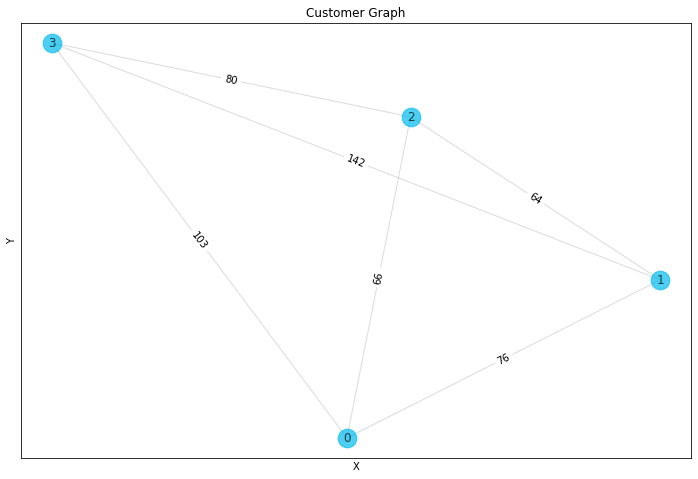

All Hamiltonian Paths from 0-3 :
 [[0, 1, 2, 3], [0, 2, 1, 3]] 

[0, 1, 2, 3]: 225
[0, 2, 1, 3]: 277
Minimum Cost for Zone 0: [0, 1, 2, 3] : 225
{(0, 1): 76, (1, 2): 64, (2, 3): 80, (3, 0): 103}


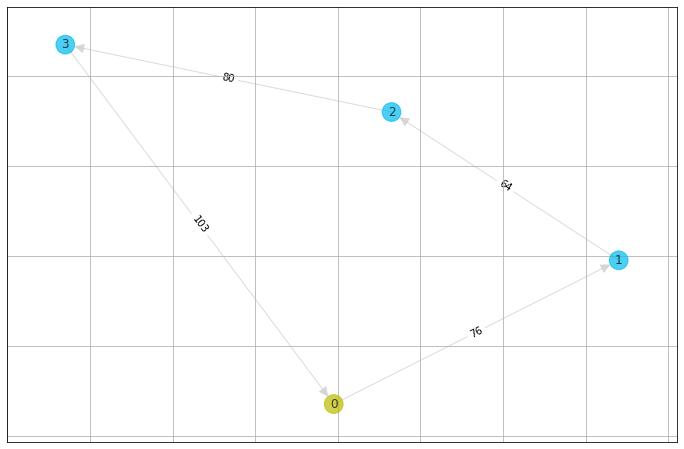

xs:  [1079, 951, 971, 1035] ys:  [507, 585, 518, 744]

----For Zone 1----
distance matrix : 
 [[  0.         149.89329538 108.55873986 241.04978739]
 [149.89329538   0.          69.92138443 179.82491485]
 [108.55873986  69.92138443   0.         234.88720697]
 [241.04978739 179.82491485 234.88720697   0.        ]]
{0: (1079, 507), 4: (951, 585), 5: (971, 518), 6: (1035, 744)}
{(0, 4): 149, (0, 5): 108, (0, 6): 241, (4, 5): 69, (4, 6): 179, (5, 6): 234}


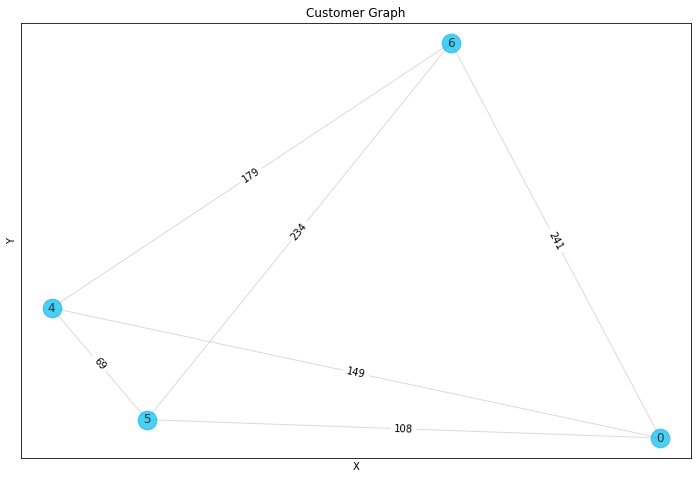

All Hamiltonian Paths from 0-6 :
 [[0, 4, 5, 6], [0, 5, 4, 6]] 

[0, 4, 5, 6]: 457
[0, 5, 4, 6]: 361
Minimum Cost for Zone 1: [0, 5, 4, 6] : 361
{(0, 5): 149, (4, 6): 234, (5, 4): 69, (6, 0): 241}


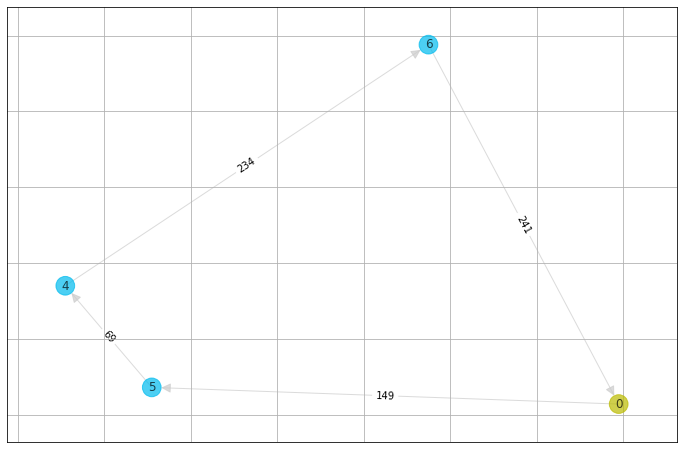

xs:  [1079, 978, 958, 873] ys:  [507, 771, 710, 741]

----For Zone 2----
distance matrix : 
 [[  0.         282.66057383 236.32604596 311.75631509]
 [282.66057383   0.          64.19501538 109.20164834]
 [236.32604596  64.19501538   0.          90.47651629]
 [311.75631509 109.20164834  90.47651629   0.        ]]
{0: (1079, 507), 7: (978, 771), 8: (958, 710), 9: (873, 741)}
{(0, 7): 282, (0, 8): 236, (0, 9): 311, (7, 8): 64, (7, 9): 109, (8, 9): 90}


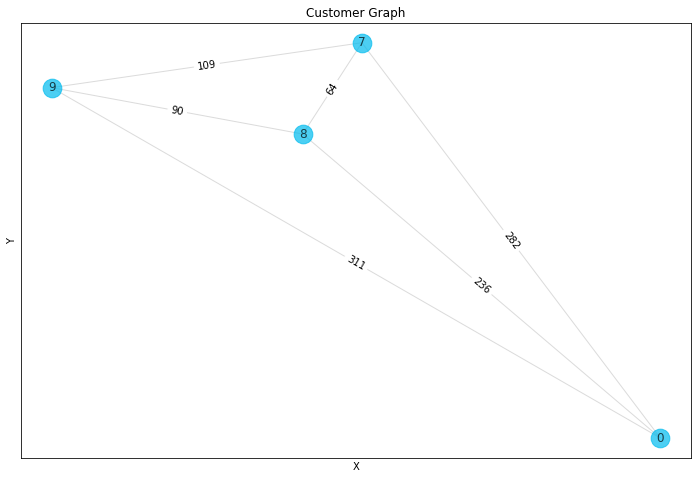

All Hamiltonian Paths from 0-9 :
 [[0, 7, 8, 9], [0, 8, 7, 9]] 

[0, 7, 8, 9]: 441
[0, 8, 7, 9]: 414
Minimum Cost for Zone 2: [0, 8, 7, 9] : 414
{(0, 8): 282, (7, 9): 90, (8, 7): 64, (9, 0): 311}


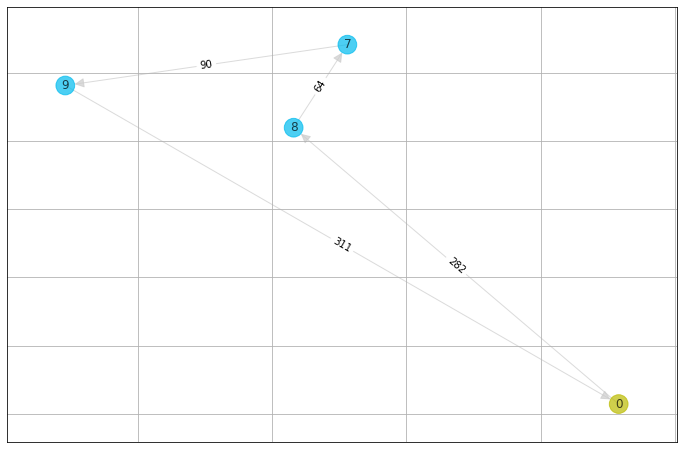

xs:  [1079, 797, 861, 780] ys:  [507, 722, 674, 632]

----For Zone 3----
distance matrix : 
 [[  0.         354.61105454 274.61427494 324.07715131]
 [354.61105454   0.          80.          91.59148432]
 [274.61427494  80.           0.          91.24143795]
 [324.07715131  91.59148432  91.24143795   0.        ]]
{0: (1079, 507), 10: (797, 722), 11: (861, 674), 12: (780, 632)}
{(0, 10): 354, (0, 11): 274, (0, 12): 324, (10, 11): 80, (10, 12): 91, (11, 12): 91}


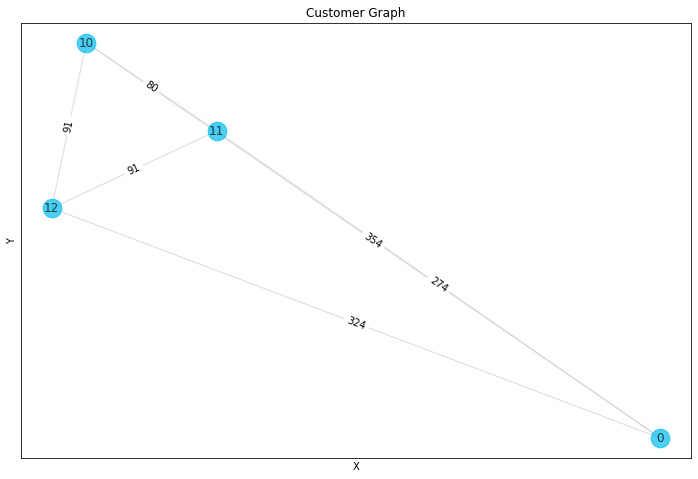

All Hamiltonian Paths from 0-12 :
 [[0, 10, 11, 12], [0, 11, 10, 12]] 

[0, 10, 11, 12]: 530
[0, 11, 10, 12]: 450
Minimum Cost for Zone 3: [0, 11, 10, 12] : 450
{(0, 11): 354, (10, 12): 91, (11, 10): 80, (12, 0): 324}


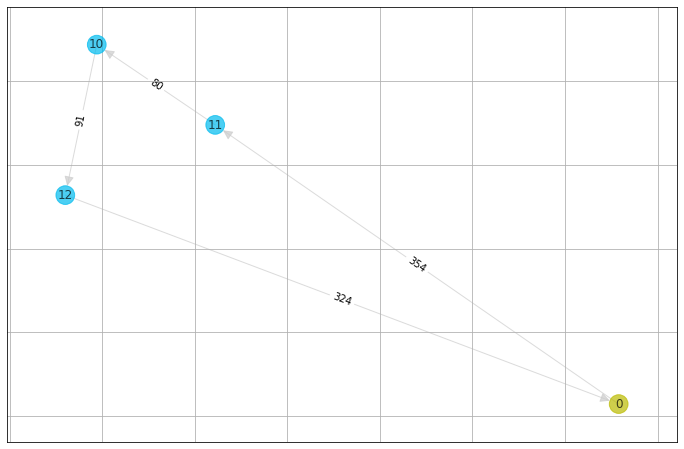

xs:  [1079, 702, 775, 659] ys:  [507, 568, 569, 712]

----For Zone 4----
distance matrix : 
 [[  0.         381.90312908 310.25795719 467.35960459]
 [381.90312908   0.          73.00684899 150.28306625]
 [310.25795719  73.00684899   0.         184.13310403]
 [467.35960459 150.28306625 184.13310403   0.        ]]
{0: (1079, 507), 13: (702, 568), 14: (775, 569), 15: (659, 712)}
{(0, 13): 381, (0, 14): 310, (0, 15): 467, (13, 14): 73, (13, 15): 150, (14, 15): 184}


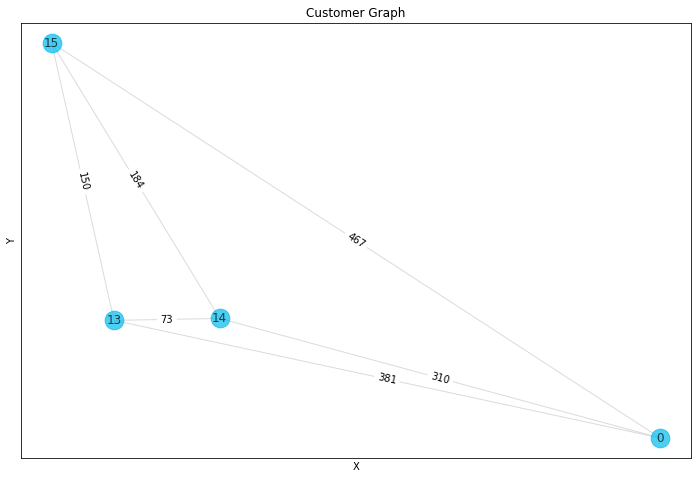

All Hamiltonian Paths from 0-15 :
 [[0, 13, 14, 15], [0, 14, 13, 15]] 

[0, 13, 14, 15]: 643
[0, 14, 13, 15]: 538
Minimum Cost for Zone 4: [0, 14, 13, 15] : 538
{(0, 14): 381, (13, 15): 184, (14, 13): 73, (15, 0): 467}


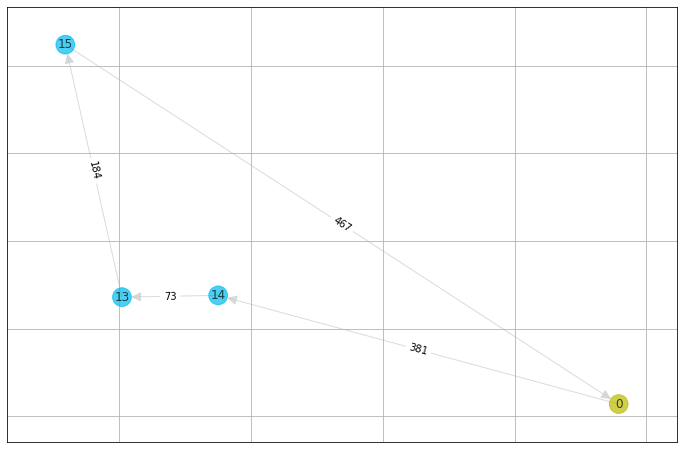

xs:  [1079, 647, 577, 550] ys:  [507, 775, 773, 678]

----For Zone 5----
distance matrix : 
 [[  0.         508.37781226 568.1197057  555.95143673]
 [508.37781226   0.          70.0285656  137.17871555]
 [568.1197057   70.0285656    0.          98.762341  ]
 [555.95143673 137.17871555  98.762341     0.        ]]
{0: (1079, 507), 16: (647, 775), 17: (577, 773), 18: (550, 678)}
{(0, 16): 508, (0, 17): 568, (0, 18): 555, (16, 17): 70, (16, 18): 137, (17, 18): 98}


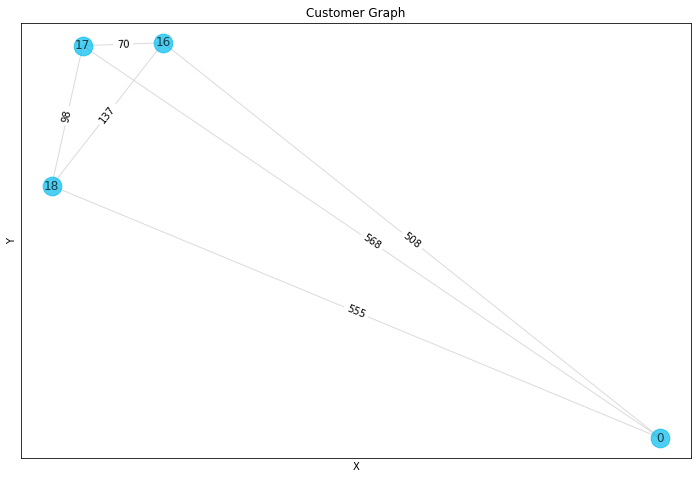

All Hamiltonian Paths from 0-18 :
 [[0, 16, 17, 18], [0, 17, 16, 18]] 

[0, 16, 17, 18]: 681
[0, 17, 16, 18]: 780
Minimum Cost for Zone 5: [0, 16, 17, 18] : 681
{(0, 16): 508, (16, 17): 70, (17, 18): 98, (18, 0): 555}


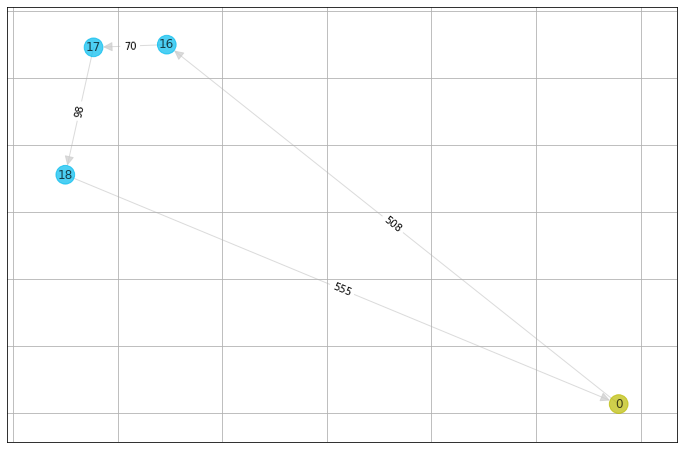

xs:  [1079, 552, 621, 431] ys:  [507, 612, 638, 654]

----For Zone 6----
distance matrix : 
 [[  0.         537.35835343 476.36645558 664.464446  ]
 [537.35835343   0.          73.73601562 128.08200498]
 [476.36645558  73.73601562   0.         190.67249408]
 [664.464446   128.08200498 190.67249408   0.        ]]
{0: (1079, 507), 19: (552, 612), 20: (621, 638), 21: (431, 654)}
{(0, 19): 537, (0, 20): 476, (0, 21): 664, (19, 20): 73, (19, 21): 128, (20, 21): 190}


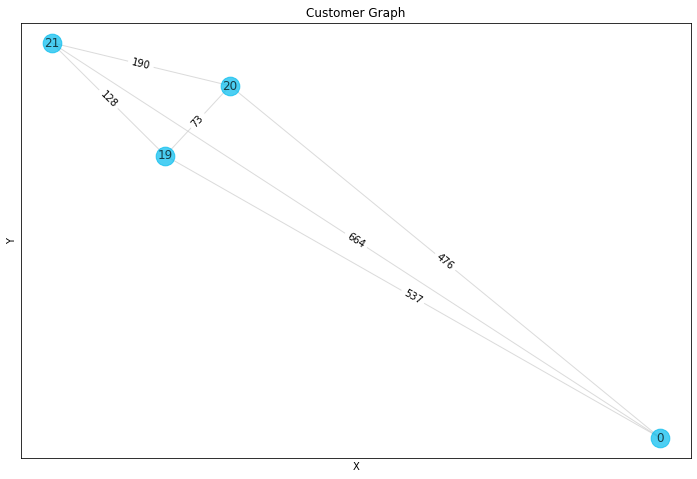

All Hamiltonian Paths from 0-21 :
 [[0, 19, 20, 21], [0, 20, 19, 21]] 

[0, 19, 20, 21]: 805
[0, 20, 19, 21]: 682
Minimum Cost for Zone 6: [0, 20, 19, 21] : 682
{(0, 20): 537, (19, 21): 190, (20, 19): 73, (21, 0): 664}


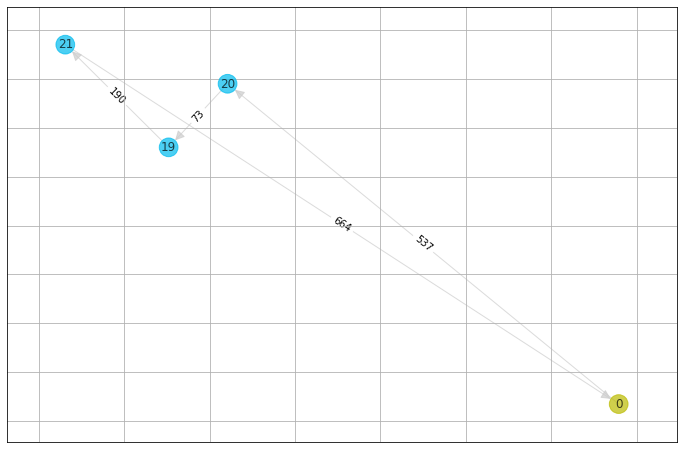

xs:  [1079, 405, 340, 190] ys:  [507, 722, 721, 726]

----For Zone 7----
distance matrix : 
 [[  0.         707.46095299 769.36142352 915.57741344]
 [707.46095299   0.          65.00769185 215.03720608]
 [769.36142352  65.00769185   0.         150.0833102 ]
 [915.57741344 215.03720608 150.0833102    0.        ]]
{0: (1079, 507), 22: (405, 722), 23: (340, 721), 24: (190, 726)}
{(0, 22): 707, (0, 23): 769, (0, 24): 915, (22, 23): 65, (22, 24): 215, (23, 24): 150}


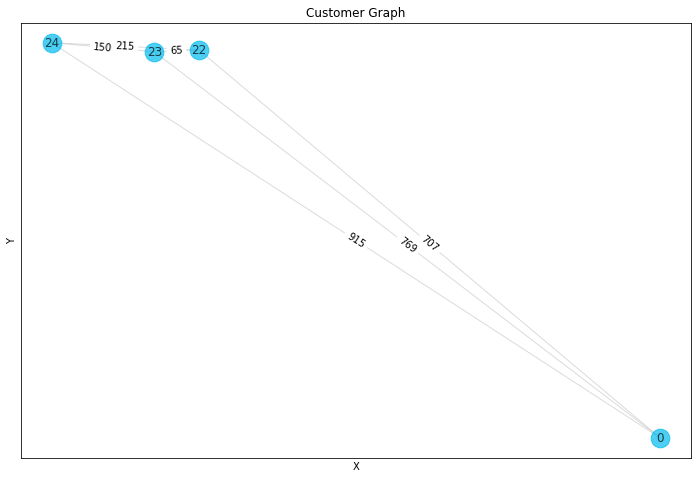

All Hamiltonian Paths from 0-24 :
 [[0, 22, 23, 24], [0, 23, 22, 24]] 

[0, 22, 23, 24]: 927
[0, 23, 22, 24]: 1054
Minimum Cost for Zone 7: [0, 22, 23, 24] : 927
{(0, 22): 707, (22, 23): 65, (23, 24): 150, (24, 0): 915}


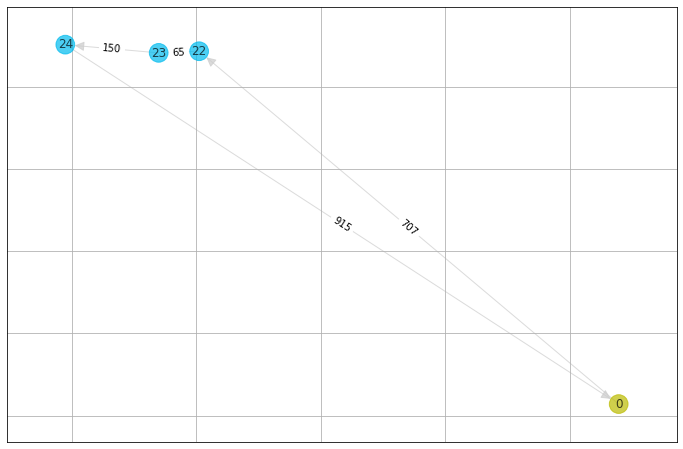

xs:  [1079, 128, 189, 352] ys:  [507, 697, 648, 510]

----For Zone 8----
distance matrix : 
 [[  0.         969.79430809 901.09988348 727.00618979]
 [969.79430809   0.          78.24321057 291.79616173]
 [901.09988348  78.24321057   0.         213.57200191]
 [727.00618979 291.79616173 213.57200191   0.        ]]
{0: (1079, 507), 25: (128, 697), 26: (189, 648), 27: (352, 510)}
{(0, 25): 969, (0, 26): 901, (0, 27): 727, (25, 26): 78, (25, 27): 291, (26, 27): 213}


In [ ]:
#Classical - Brute force solution
solutions=[]
for zone_id in range(len(zones)):
    nodes_for_zone=zones[zone_id]
    instance=create_distance_matrix_for_zone(zone_id)
    print ("\n----For Zone %s----"%zone_id)
    print ('distance matrix : \n',instance)
    X = nx.Graph()
    pos = {}
    plot_nodes(X,zone_id)
    selectedPaths = get_hamiltonian_paths(X,nodes_for_zone[3])
    print('All Hamiltonian Paths from 0-%s :\n'%nodes_for_zone[3],list(selectedPaths),'\n')
    min_cost, min_cost_path = get_min_cost_function(selectedPaths)
    print('Minimum Cost for Zone {}: {} : {}'.format(zone_id, min_cost_path, min_cost))
    
    #Create the adjacency matrix
    x=np.zeros((n,n), dtype=int)
    #for k in range(len(min_cost_path)-1):
    #    x[min_cost_path[k]][min_cost_path[k+1]]=1
    #x[min_cost_path[k+1]][0]=1
    #x=x.flatten()
    #print(x) 


    draw_tsp_solution(X,min_cost_path,pos)
    solutions.append(min_cost_path)

In [79]:
def get_coordinates_array(xs,ys):
    coords=[[]] * len(xs)
    for i in range(len(xs)):
        coords[i]=([xs[i],ys[i]])
    return coords

def shift_solution_nodes(z):
    z2 = np.zeros(len(z), dtype=int)
    i = z.index(0)
    roll_by = len(z)-i
    z1 = np.roll(z,roll_by)
    keys = list(pos.keys())
    for i in range(len(z)):
        z2[i] = keys[z1[i]]
    return z2


[[1079, 507], [552, 612], [621, 638], [431, 654]]


In [81]:
from qiskit.aqua.translators.ising import tsp
for zone_id in range(len(zones)):
#n = 3
coord=get_coordinates_array(xs,ys)
print (coord)
#num_qubits = n ** 2
#ins = tsp.random_tsp(n)
#insList = list(ins)
#It is important to real
"""
coord = [[5.5100391375334326, 7.9872448071072135],
    [7.559639370825573, 2.2741572523311104],
    [4.357164910072608, 6.055345738402197],
    [0.4293142250893367, 5.7923100691603135]]
"""
ins = tsp.TspData(name='AMC', dim=4, coord=coord, w=instance)
print(ins)
qubitOp, offset = tsp.get_tsp_qubitops(ins)
algo_input = EnergyInput(qubitOp)
print('Paulis: ',qubitOp.aer_paulis,'\n')
print('Flat Paulis: ',qubitOp.get_flat_pauli_list(),'\n')
#print('\nmatrix: ',qubitOp.matrix,'\n')
print('num qubits: ',qubitOp.num_qubits,'\n')
print('Algorithm Input: ',algo_input,'\n')
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()
print('energy:', result['energy'])
print('tsp objective:', result['energy'] + offset)
import sys
np.set_printoptions(threshold=1000)
print(result['eigvecs'])
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
z2 = shift_solution_nodes(z)
print(z2)
print(pos)
#draw_tsp_solution(G, best_order, colors, pos)
draw_tsp_solution(X, z2, pos)

TspData(name='AMC', dim=4, coord=[[1079, 507], [552, 612], [621, 638], [431, 654]], w=array([[  0.        , 707.46095299, 769.36142352, 915.57741344],
       [707.46095299,   0.        ,  65.00769185, 215.03720608],
       [769.36142352,  65.00769185,   0.        , 150.0833102 ],
       [915.57741344, 215.03720608, 150.0833102 ,   0.        ]]))
Paulis:  [[[-201196.1998949724, 0.0], 'IIIIIIIIIIIIIIIZ'], [[-200493.75292546087, 0.0], 'IIIIIIIIIIZIIIII'], [[176.86523824652485, 0.0], 'IIIIIIIIIIZIIIIZ'], [[-201196.1998949724, 0.0], 'IIIIIIIIIIIIIIZI'], [[-200493.75292546087, 0.0], 'IIIIIIIIIZIIIIII'], [[176.86523824652485, 0.0], 'IIIIIIIIIZIIIIZI'], [[-201196.1998949724, 0.0], 'IIIIIIIIIIIIIZII'], [[-200493.75292546087, 0.0], 'IIIIIIIIZIIIIIII'], [[176.86523824652485, 0.0], 'IIIIIIIIZIIIIZII'], [[-201196.1998949724, 0.0], 'IIIIIIIIIIIIZIII'], [[-200493.75292546087, 0.0], 'IIIIIIIIIIIZIIII'], [[176.86523824652485, 0.0], 'IIIIIIIIIIIZZIII'], [[-200492.22621278506, 0.0], 'IIIIIIZIIIIIIIII'], 

/opt/conda/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:986: DeprecationWarning: get_flat_pauli_list() is deprecated and it will be removed after 0.6. Use `reorder_paulis()` instead
  DeprecationWarning)


energy: -1603806.9266276816
tsp objective: 1838.1293684754055
[[0. 0. 0. ... 0. 0. 0.]]
feasible: True
solution: [2, 3, 0, 1]
solution objective: 1838.129368475907
[ 0 22 23 24]
{0: (1079, 507), 22: (405, 722), 23: (340, 721), 24: (190, 726)}


[ 0 23 24 22]
{0: (1079, 507), 22: (405, 722), 23: (340, 721), 24: (190, 726)}


{(0, 22): 707, (22, 23): 65, (23, 24): 150, (24, 0): 915}


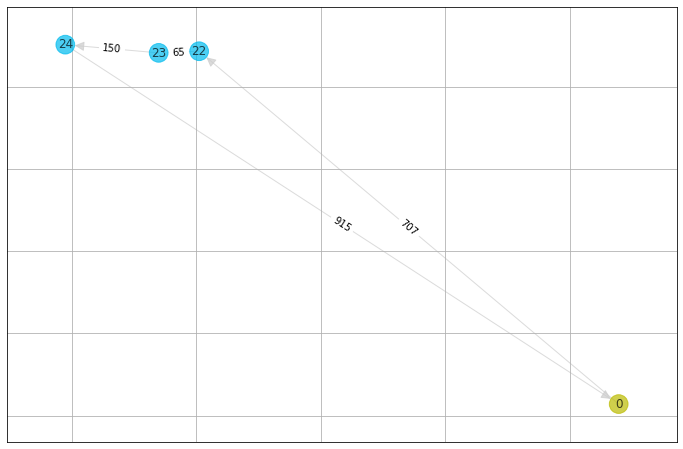

In [106]:
seed = 10598
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

#Now we use the VQE that needs two algorithms as sub-components
#Sub-Component 1 : a local optimizer, we use SPSA/COBYLA(Constrained Optimization BY Linear Approximation) 
#from qiskit.aqua.components.optimizers
cobyla = COBYLA()
cobyla.set_options(maxiter=250)
spsa = SPSA(max_trials=200)
#Sub-Component 2 : a variational form, we use Ry from qiskit.aqua.components.variational_forms
#ry = RY(qubitOp.num_qubits, depth=3, entanglement='full')
ry = RY(qubitOp.num_qubits, depth=3, entanglement='linear')
vqe = VQE(qubitOp, ry, cobyla, 'matrix')
#vqe = VQE(qubitOp, ry, spsa, 'matrix')
vqe.random_seed = seed

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_transpiler=seed)

import time
start_time=time.time()
result = vqe.run(quantum_instance)
print("Ran For %s seconds" % (time.time() - start_time))
"""
algorithm_cfg = {
    'name': 'VQE',
    'operator_mode': 'matrix'
}

optimizer_cfg = {
    'name': 'SPSA',
    'max_trials': 300
}

var_form_cfg = {
    'name': 'RY',
    'depth': 5,
    'entanglement': 'linear'
}

params = {
    'problem': {'name': 'ising', 'random_seed': seed},
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg,
    'backend': {'provider': 'qiskit.BasicAer', 'name': 'statevector_simulator'}
}
result = run_algorithm(parahms,algo_input)
"""

2019-08-29 13:16:08,733:qiskit.aqua.parser.json_schema:DEBUG: Input: {
    "disp": false,
    "maxiter": 1000,
    "rhobeg": 1.0,
    "tol": null
}
2019-08-29 13:16:08,734:qiskit.aqua.parser.json_schema:DEBUG: Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "cobyla_schema",
    "properties": {
        "disp": {
            "default": false,
            "type": "boolean"
        },
        "maxiter": {
            "default": 1000,
            "type": "integer"
        },
        "rhobeg": {
            "default": 1.0,
            "type": "number"
        },
        "tol": {
            "default": null,
            "type": [
                "number",
                "null"
            ]
        }
    },
    "type": "object"
}
2019-08-29 13:16:08,737:qiskit.aqua.components.optimizers.optimizer:DEBUG: options: {'maxiter': 250, 'disp': False, 'rhobeg': 1.0}
2019-08-29 13:16:08,738:qiskit.aqua.parser.json_schema:DEBUG: Input: {
  

Ran For 398.89266896247864 seconds


"\nalgorithm_cfg = {\n    'name': 'VQE',\n    'operator_mode': 'matrix'\n}\n\noptimizer_cfg = {\n    'name': 'SPSA',\n    'max_trials': 300\n}\n\nvar_form_cfg = {\n    'name': 'RY',\n    'depth': 5,\n    'entanglement': 'linear'\n}\n\nparams = {\n    'problem': {'name': 'ising', 'random_seed': seed},\n    'algorithm': algorithm_cfg,\n    'optimizer': optimizer_cfg,\n    'variational_form': var_form_cfg,\n    'backend': {'provider': 'qiskit.BasicAer', 'name': 'statevector_simulator'}\n}\nresult = run_algorithm(parahms,algo_input)\n"

{'num_optimizer_evals': 250, 'min_val': -1498417.626426007, 'opt_params': array([-1.28604464e+00, -3.02845570e+00, -7.07057591e-01,  2.67470557e+00,
       -2.14908413e+00, -1.61468853e+00,  2.80670816e+00,  2.56964767e+00,
        9.31822804e-01, -1.86774354e+00,  2.01706071e+00,  2.34976169e-01,
       -1.05238765e+00,  1.94705776e+00,  5.97695219e-01, -2.40526541e+00,
        4.16368953e+00, -4.63965243e-01,  4.21148442e-01,  1.22007251e-01,
       -2.63248336e+00,  2.44381151e+00,  8.03626749e-01, -3.11231767e+00,
       -3.45799950e-01, -3.02223478e+00, -1.98238922e+00, -1.76435360e-01,
       -2.93212121e+00,  2.98007676e+00, -1.32963777e-01,  4.59755925e-01,
       -4.63541271e-01,  2.32201567e+00,  3.43350108e+00,  7.04127845e-01,
        4.35815219e+00, -2.46525258e+00,  3.77914800e+00,  5.94157179e-01,
       -8.79640568e-01,  2.94655049e+00,  4.86968491e+00,  8.08264666e-02,
       -6.12233769e-01,  2.35387643e+00, -2.81012856e+00,  2.14436158e+00,
       -3.90565546e-01, -1

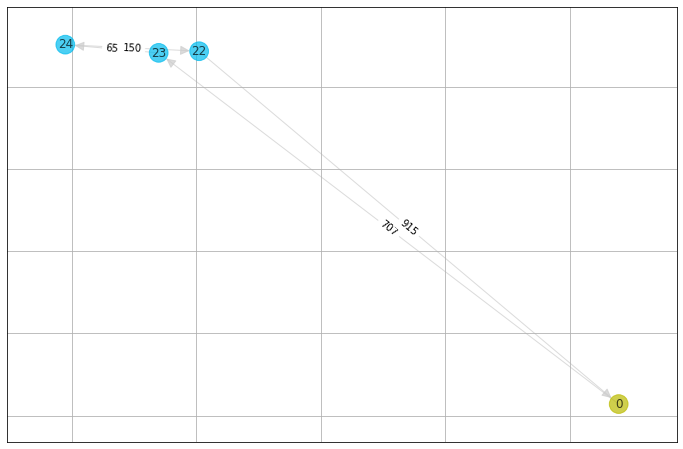

In [110]:
print(result)    
print('energy:', result['energy'])
print('time:', result['eval_time'])
#print('tsp objective:', result['energy'] + offset)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
z2 = shift_solution_nodes(z)
print(z2)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(X, z2, pos)

In [1]:
#Aggregation
#You will have 20 z arrays - 
#[[0,1,2,3], [0,7,6,8], [0,9,11,10]...]
#3, 8, 10, .... - with these create an array
edges = []
nodes_to_join = []
k=0
for solution in solutions:
#3 & 8 - whether their distance is less than threshold
    #Select nodes to join
    for i in range(len(solution)-1):
        edges.append([solution[i],solution[i+1],'#555555',1])
    print (solution)
    if k%2==0: #Even
        nodes_to_join.append(solution[3])
    else : #Odd
        nodes_to_join.append(solution[1])
        nodes_to_join.append(solution[3])
    k=k+1

print(nodes_to_join)
continue_joining=True
while(continue_joining):
    deleted=False
    for k in range(len(nodes_to_join)-1):
        nodeA=nodes_to_join[k]
        nodeB=nodes_to_join[k+1]
        distance = math.sqrt((nodes[nodeA]['x'] - nodes[nodeB]['x']) ** 2 + (nodes[nodeA]['y'] - nodes[nodeB]['y']) ** 2)
        print(nodeA,nodeB," --- ",distance)
        if distance < 100:
            edges.append([nodeA,nodeB,'#cc0000',2])
            nodes_to_join.remove(nodeA)
            nodes_to_join.remove(nodeB)
            deleted=True
            break
    print(nodes_to_join)
    if deleted==False:
        continue_joining=False

#if it is - the join 3-8 and remove 3,8 from the array
for k in range(len(nodes_to_join)):
    edges.append([nodes_to_join[k],0,'#0000cc',2])

NameError: name 'solutions' is not defined